Find the data here:
https://nemar.org/dataexplorer/detail?dataset_id=ds005420

In [1]:
import os
import re
import mne
import warnings
import numpy as np
import matplotlib.pyplot as plt

from os.path import join

import pandas as pd
from tqdm.notebook import tqdm
from mne.preprocessing import ICA, create_eog_epochs

In [2]:
def process_eeg(eeg_data, sample_rate):
    eeg_data.set_eeg_reference(ref_channels='average', projection=False)
    eeg_data.resample(sample_rate, method='fft')
    return eeg_data

In [3]:
pattern = r'sub-\d+'
path_data = 'eeg_data'
data_array_oc = []
data_array_oa = []
subject_ids = []
samplerate = 250   # The data is originally sampled at 500 Hz
invalid_indexes = []

for i, folder_name in tqdm(enumerate(os.listdir(path_data)), total=len(os.listdir(path_data))):
    if re.match(pattern, folder_name):
        subject_ids.append(folder_name)
        edf_path_oc = join(path_data, folder_name, "eeg", f"{folder_name}_task-oc_eeg.edf")
        edf_path_oa = edf_path_oc.replace('oc', 'oa')
        
        try:
            data = mne.io.read_raw_edf(edf_path_oc, preload=True, verbose=False)
            data_processed = process_eeg(data, samplerate)
            data_array_oc.append(data_processed)
        except FileNotFoundError:
            print(f'OC data missing for {folder_name}')
            data_array_oc.append(None)
            invalid_indexes.append(len(data_array_oc) - 1)
        
        try:
            data = mne.io.read_raw_edf(edf_path_oa, preload=True, verbose=False)
            data_processed = process_eeg(data, samplerate)
            data_array_oa.append(data_processed)
        except FileNotFoundError:
            print(f'OA data missing for {folder_name}')
            data_array_oa.append(None)
            invalid_indexes.append(len(data_array_oc) - 1)
        
        assert len(data_array_oc) == len(data_array_oa)

for i, index in enumerate(invalid_indexes):
    data_array_oc.pop(index - i)
    data_array_oa.pop(index - i)
    subject_ids.pop(index - i)

  0%|          | 0/44 [00:00<?, ?it/s]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

C:\Users\toell\AppData\Local\Temp\ipykernel_17384\2932651507.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\toell\AppData\Local\Temp\ipykernel_17384\2932651507.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\toell\AppData\Local\Temp\ipykernel_17384\2932651507.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oc, preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\toell\AppData\Local\Temp\ipykernel_17384\2932651507.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(edf_path_oa, preload=True, verbose=False)


In [4]:
def plot_raw_data(subject_ids, data_array_oc, data_array_oa, subject_slice, channel_slice, filter_values, plot_time, average_psd=False):
    warnings.filterwarnings("ignore")
    for name, arr_oc, arr_oa in zip(subject_ids, data_array_oc[subject_slice], data_array_oa[subject_slice]):
        data_filtered_oc = arr_oc.copy().filter(*filter_values, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
        if plot_time:
            print(f"OC for {name}")
            data_filtered_oc.plot()
        else:
            data_filtered_oc.compute_psd(verbose=False).plot(average=average_psd, picks="data", amplitude=False)
            plt.title(f"OC for {name}")
            plt.show()
        
        data_filtered_oa = arr_oa.copy().filter(*filter_values, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
        if plot_time:
            print(f"OA for {name}")
            data_filtered_oa.plot()
        else:
            data_filtered_oa.compute_psd(verbose=False).plot(average=average_psd, picks="data", amplitude=False)
            plt.title(f"OA for {name}")
            plt.show()
    warnings.filterwarnings("default")

OC for sub-1
Using matplotlib as 2D backend.


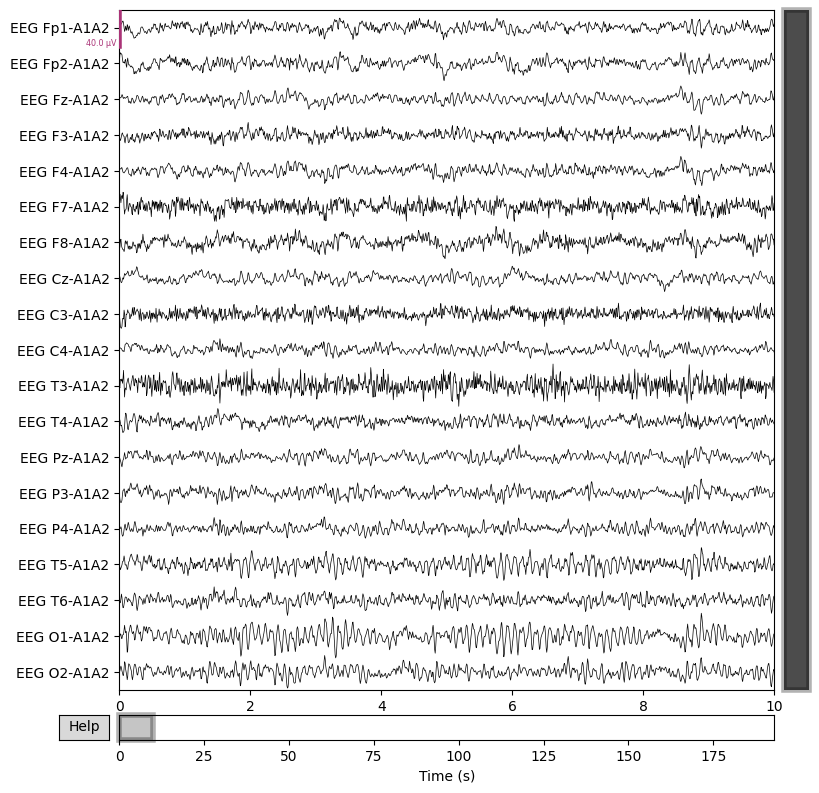

OA for sub-1


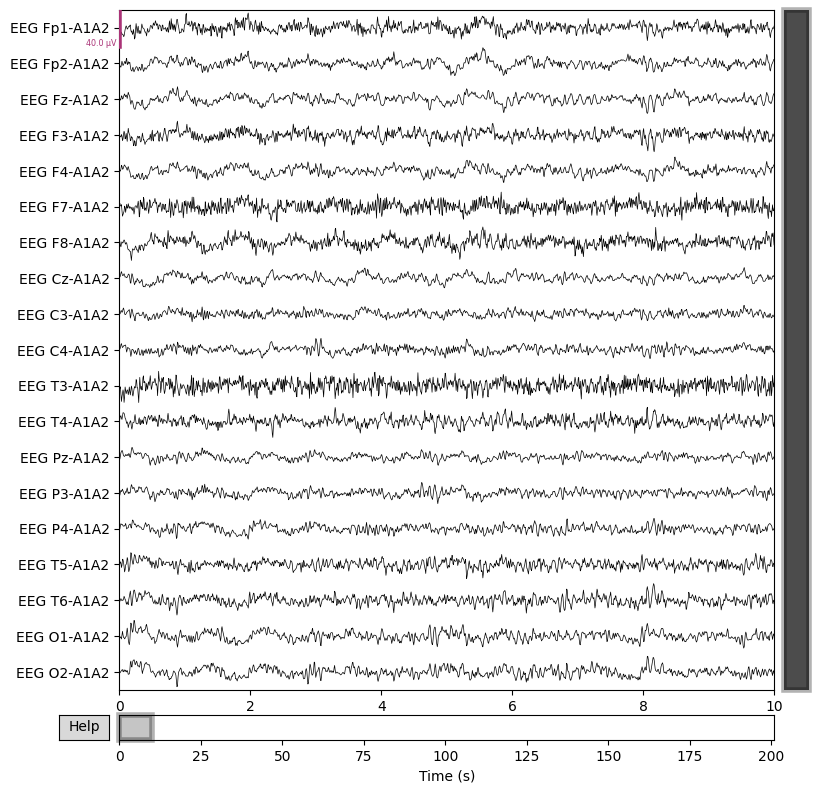

In [5]:
channel_slice = slice(0, -1)
subject_slice = slice(1, 2)
filter_values = 1, 40
plot_raw_data(subject_ids, data_array_oc, data_array_oa, subject_slice, channel_slice, filter_values, plot_time=True)

Plotting power spectral density (dB=True).


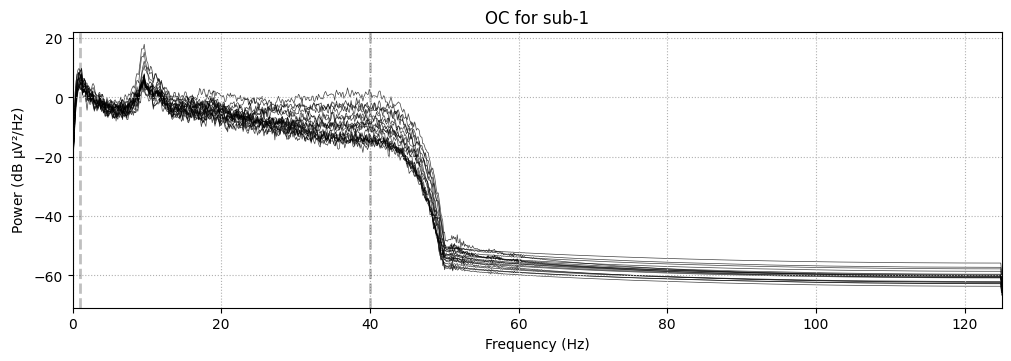

Plotting power spectral density (dB=True).


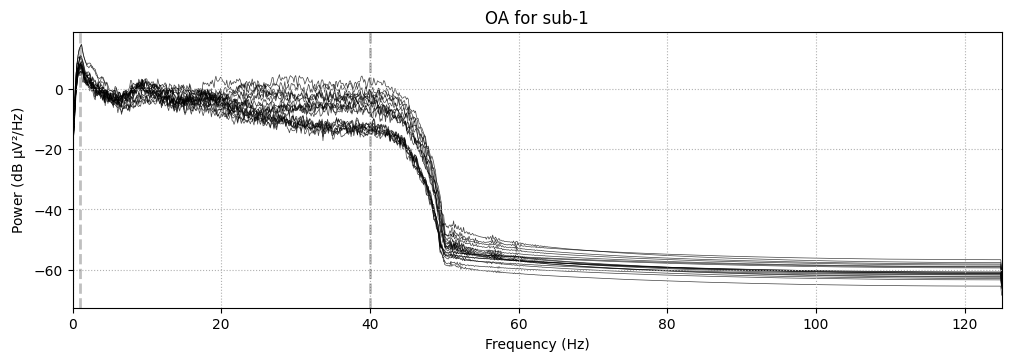

In [6]:
import warnings
channel_slice = slice(0, -1)
subject_slice = slice(1, 2)
filter_values = 1, 40

plot_raw_data(subject_ids, data_array_oc, data_array_oa, subject_slice, channel_slice, filter_values, plot_time=False)

Calculate Alpha frequency

  0%|          | 0/35 [00:00<?, ?it/s]

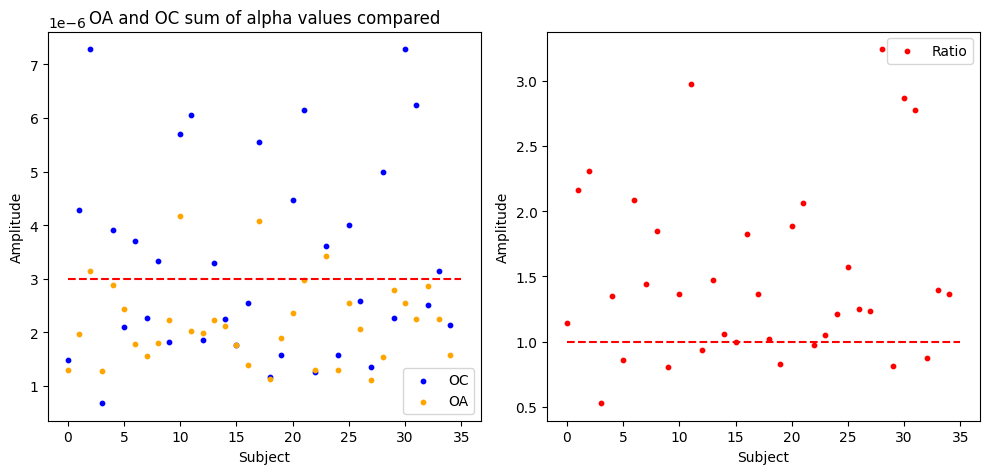

In [7]:
filter_alpha = (8, 12)
channel_slice = slice(17, 19)
alphas_oc, alphas_oa = [], []
section_size = 300 * samplerate     # seconds * sample_rate

for name, data_oc, data_oa in tqdm(zip(subject_ids, data_array_oc, data_array_oa), total=len(subject_ids)):
    data_filtered_oc_alpha = data_oc.copy().filter(*filter_alpha, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
    data_filtered_oa_alpha = data_oa.copy().filter(*filter_alpha, fir_design='firwin', phase='zero', verbose=False).pick(channel_slice)
    
    arr_oc = data_filtered_oc_alpha.get_data()
    acc_oa = data_filtered_oa_alpha.get_data()
    
    num_sections = arr_oc.shape[1] // section_size
    for i in range(1):
        alpha_oc = np.abs(data_filtered_oc_alpha.get_data()[:, i:(i+1)*section_size]).mean()
        alpha_oa = np.abs(data_filtered_oa_alpha.get_data()[:, i:(i+1)*section_size]).mean()
        alphas_oc.append(alpha_oc)
        alphas_oa.append(alpha_oa)
    
alphas_oc, alphas_oa = np.array(alphas_oc).flatten(), np.array(alphas_oa).flatten()

s = 10 
fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
plt.hlines(3.0 * 1e-6, 0, len(alphas_oc), linestyles='dashed', color='red')
plt.title('OA and OC sum of alpha values compared')
plt.xlabel('Subject')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(range(len(alphas_oc)), alphas_oc / alphas_oa, label='Ratio', color='red', s=s)
plt.hlines(1, 0, len(alphas_oc), linestyles='dashed', color='red')
plt.xlabel('Subject')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
indexes_for_exercise = np.argwhere(alphas_oc > 3 * 1e-6).astype(int).flatten()

In [12]:
def save_subject_data(data_array_oc, data_array_oa, subject_ids, indexes, output_folder_name, section_size):
    
    for idx in tqdm(indexes, desc="Saving Subject Data"):
        path_subject_data = join(f"{output_folder_name}-{section_size}", subject_ids[idx])
        os.makedirs(path_subject_data, exist_ok=True)
        arr_oc = data_array_oc[idx].get_data()
        arr_oa = data_array_oa[idx].get_data()
        
        num_sections = arr_oc.shape[1] // section_size
        for i in range(num_sections):
            print(arr_oc[:, i*section_size:(i+1)*section_size].shape)
            df_oc = pd.DataFrame(arr_oc[:, i*section_size:(i+1)*section_size])
            df_oa = pd.DataFrame(arr_oa[:, i*section_size:(i+1)*section_size])
            
            df_oc.to_csv(join(path_subject_data, f'oc_{i}.csv'))
            df_oa.to_csv(join(path_subject_data, f'oa_{i}.csv'))

In [13]:
save_subject_data(data_array_oc, data_array_oa, subject_ids, indexes=[0], output_folder_name="data_test", section_size=30 * samplerate)

Saving Subject Data:   0%|          | 0/1 [00:00<?, ?it/s]

(20, 7500)
(20, 7500)
(20, 7500)
(20, 7500)
(20, 7500)
(20, 7500)
(20, 7500)


In [ ]:
save_subject_data(data_array_oc, data_array_oa, subject_ids, indexes=indexes_for_exercise, output_folder_name="data_for_exercise", section_size=30 * samplerate)

Saving Subject Data:   0%|          | 0/17 [00:00<?, ?it/s]

In [14]:
df = pd.read_csv(f"data_test-7500/{subject_ids[0]}/oc_0.csv")
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0,-7.454017e-06,-1.082139e-05,-1.114419e-05,-0.000012,-1.424643e-05,-1.806803e-05,-1.971452e-05,-0.000020,-0.000021,...,1.166030e-06,1.392342e-06,2.235870e-06,3.738479e-06,4.660282e-06,3.978824e-06,2.785090e-06,2.826808e-06,0.000004,5.200756e-06
1,1,-1.355730e-05,-1.769053e-05,-1.733110e-05,-0.000017,-1.936286e-05,-2.248655e-05,-2.368425e-05,-0.000024,-0.000026,...,-6.860458e-06,-7.316092e-06,-6.350030e-06,-3.835900e-06,-2.382581e-06,-3.613262e-06,-6.231803e-06,-6.929368e-06,-0.000004,1.994527e-07
2,2,1.757190e-07,8.048649e-07,-1.792398e-08,-0.000002,-1.896529e-06,-2.140133e-07,5.425904e-07,-0.000002,-0.000005,...,7.731602e-08,7.937576e-07,9.629369e-07,5.294516e-09,-1.760382e-06,-2.924560e-06,-2.768883e-06,-1.133984e-06,0.000001,3.587316e-06
3,3,1.396643e-06,3.349417e-06,3.227940e-06,0.000001,5.038085e-08,4.919216e-07,4.819656e-08,-0.000003,-0.000006,...,-1.412198e-06,9.393572e-07,2.791341e-06,2.474009e-06,8.766084e-07,-1.667397e-07,-1.580547e-07,4.531670e-07,0.000001,1.912081e-06
4,4,-4.707762e-06,-4.996374e-06,-6.195421e-06,-0.000009,-8.728332e-06,-5.144887e-06,-2.825812e-06,-0.000007,-0.000015,...,-4.163617e-06,-4.685625e-06,-5.890010e-06,-6.830643e-06,-7.881051e-06,-9.845233e-06,-1.119917e-05,-9.389144e-06,-0.000004,1.583710e-06
